# Adaptive PDE discretizations on cartesian grids 
## Volume : Reproducible research
## Part : Eikonal CPU/GPU solvers comparison
## Chapter : Rander metrics

In this notebook, we solve Rander eikonal equations on the CPU and the GPU, and check that they produce consistent results.

*Note on the numerical schemes*: The numerical schemes solved by the CPU and the GPU in the Rander case are entirely different. The CPU version uses a causal semi-Lagrangian scheme, two dimensional only, whereas the GPU version uses a non-causal (yet monotone) Eulerian scheme, in two and three dimensions.

[**Summary**](Summary.ipynb) of volume Reproducible research, this series of notebooks.

[**Main summary**](../Summary.ipynb) of the Adaptive Grid Discretizations 
	book of notebooks, including the other volumes.

# Table of contents
  * [1. Two dimensions](#1.-Two-dimensions)
    * [1.1 Constant metric](#1.1-Constant-metric)
    * [1.2 Zermelo's problem](#1.2-Zermelo's-problem)
  * [2. Three dimensions](#2.-Three-dimensions)



**Acknowledgement.** The experiments presented in these notebooks are part of ongoing research, 
some of it with PhD student Guillaume Bonnet, in co-direction with Frederic Bonnans.

Copyright Jean-Marie Mirebeau, University Paris-Sud, CNRS, University Paris-Saclay

## 0. Importing the required libraries

In [1]:
import sys; sys.path.insert(0,"..")
#from Miscellaneous import TocTools; print(TocTools.displayTOC('Rander_GPU','Repro'))

In [2]:
from agd import AutomaticDifferentiation as ad
if ad.cupy_generic.cp is None: raise ad.DeliberateNotebookError('Cupy module required')
from agd import Eikonal
from agd import Metrics
from agd import FiniteDifferences as fd
from agd import LinearParallel as lp
import agd.AutomaticDifferentiation.cupy_generic as cugen

from agd.ExportedCode.Notebooks_Repro.Isotropic_GPU import RunCompare

DeliberateNotebookError: Cupy module required

In [3]:
import cupy as cp
import numpy as np
import itertools
from matplotlib import pyplot as plt
np.set_printoptions(edgeitems=30, linewidth=100000, formatter=dict(float=lambda x: "%5.3g" % x))

In [4]:
cp = ad.functional.decorate_module_functions(cp,cugen.set_output_dtype32) # Use float32 and int32 types in place of float64 and int64
plt = ad.functional.decorate_module_functions(plt,cugen.cupy_get_args)
Eikonal.dictIn.default_mode = 'gpu'

In [5]:
def ReloadPackages():
    from Miscellaneous.rreload import rreload
    global HFMUtils,ad,cugen,RunSmart,Metrics
    Eikonal,ad,cugen,Metrics = rreload([Eikonal,ad,cugen,Metrics],"../..")    
    Eikonal.dictIn.default_mode = 'gpu'

### 0.1 Additional configuration

In [6]:
large_instances = False # True favors the GPU code (CPU times may become a big long.)
strong_anisotropy = True # True favors the CPU code 
anisotropy_bound = 20. if strong_anisotropy else 5. # Ratio between the fastest and the smallest velocity at any given point

## 1. Two dimensions

### 1.1 Constant metric

In [7]:
n=2000 if large_instances else 200
hfmIn = Eikonal.dictIn({
    'model':'Rander2',
    'seed':[0.,0.],
    'exportValues':1,
    'factoringRadius':20,
})
hfmIn.SetRect([[-1,1],[-1,1]],dimx=n+1,sampleBoundary=True)
hfmIn['metric'] = Metrics.Rander(cp.eye(2),cp.array([0.4,0.3]) )

In [8]:
gpuOut,cpuOut = RunCompare(hfmIn,check=0.01)

Setting the kernel traits.
Preparing the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.02038264274597168 seconds, and 39 iterations.
Post-Processing
--- gpu done, turning to cpu ---
Field verbosity defaults to 1
Field cosAngleMin defaults to 0.5
Field refineStencilAtWallBoundary defaults to 0
Field order defaults to 1
Field seedRadius defaults to 2
Fast marching solver completed in 0.051 s.
Solver time (s). GPU : 0.02038264274597168, CPU : 0.098. Device acceleration : 4.808012445754524
Max |gpuValues-cpuValues| :  0.006902324830275752


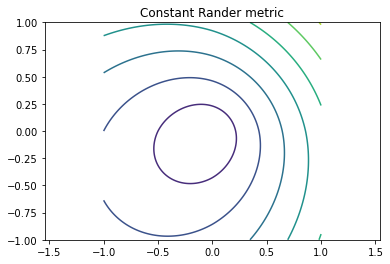

In [9]:
plt.title("Constant Rander metric"); plt.axis('equal')
plt.contour(*hfmIn.Grid(),gpuOut['values']);

### 1.2 Zermelo's problem

We obtain $\times 40$ speedup at resolution $2000\times 2000$ already. The lack of causality does not seem to be a significant issue for the GPU solver. The cost of the FM-ASR adaptive stencils cannot be neglected. 

In [10]:
n=4000 if large_instances else 1000
hfmIn = Eikonal.dictIn({
    'model':'Rander2',
    'seed':[0.,0.],
    'exportValues':1,
#    'traits':{'niter_i':12},'fim_front_width':8,
})
hfmIn.SetRect([[-2.*np.pi,2.*np.pi],[-2.*np.pi,2.*np.pi]],dimx=n+1)

In [11]:
def Drift(x,mu):
    rho = (mu-1)/(mu+1)
    mult = rho*np.prod(np.sin(x),axis=0) / np.linalg.norm(x,axis=0)
    mult[np.isnan(mult)]=0.
    return mult*x

In [12]:
hfmIn['metric']=Metrics.Rander.from_Zermelo(cp.eye(2),Drift(hfmIn.Grid(),mu=anisotropy_bound))

In [13]:
gpuOut,cpuOut = RunCompare(hfmIn,check=0.05);

Setting the kernel traits.
Preparing the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.08374238014221191 seconds, and 192 iterations.
Post-Processing
--- gpu done, turning to cpu ---
Field verbosity defaults to 1
Field cosAngleMin defaults to 0.5
Field refineStencilAtWallBoundary defaults to 0
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 1.815 s.
Solver time (s). GPU : 0.08374238014221191, CPU : 3.045. Device acceleration : 36.36151724884054
Max |gpuValues-cpuValues| :  0.04043988922236785


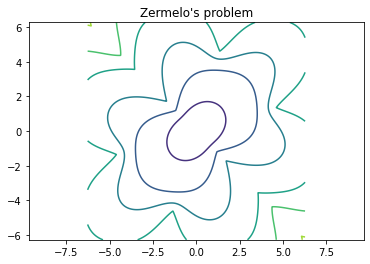

In [14]:
plt.title("Zermelo's problem"); plt.axis('equal')
plt.contour(*hfmIn.Grid(),gpuOut['values']);

In [15]:
n=200; hfmInS = hfmIn.copy() # Define a small instance for validation with multiple options
hfmInS.SetRect([[-2.*np.pi,2.*np.pi],[-2.*np.pi,2.*np.pi]],dimx=n+1)
hfmInS.update({
    'metric' : Metrics.Rander.from_Zermelo(cp.eye(2),Drift(hfmInS.Grid(),mu=anisotropy_bound)),
    'verbosity':0,
    'exportGeodesicFlow':True,
})

In [16]:
RunCompare(hfmInS,variants='basic',check=0.2)

Solver time (s). GPU : 0.016954660415649414, CPU : 0.10200000000000001. Device acceleration : 6.01604499880472
Max |gpuValues-cpuValues| :  0.1749705144348992

 --- Variant {'multiprecision': True} ---
Solver time (s). GPU : 0.01994466781616211, CPU : 0.10300000000000001. Device acceleration : 5.164287565448156
Max |gpuValues-cpuValues| :  0.17496526922615896

 --- Variant {'seedRadius': 2.0} ---
Solver time (s). GPU : 0.01894855499267578, CPU : 0.10300000000000001. Device acceleration : 5.435770698072375
Max |gpuValues-cpuValues| :  0.1660289070327492

 --- Variant {'seedRadius': 2.0, 'multiprecision': True} ---
Solver time (s). GPU : 0.01992654800415039, CPU : 0.101. Device acceleration : 5.068614994376511
Max |gpuValues-cpuValues| :  0.16602413866116716


In [17]:
RunCompare(hfmInS,variants='ext',check=0.2)

Solver time (s). GPU : 0.016078948974609375, CPU : 0.10300000000000001. Device acceleration : 6.405891340450771
Max |gpuValues-cpuValues| :  0.1749705144348992

 --- Variant {'multiprecision': True} ---
Solver time (s). GPU : 0.019969940185546875, CPU : 0.10200000000000001. Device acceleration : 5.107676790830946
Max |gpuValues-cpuValues| :  0.17496526922615896

 --- Variant {'seedRadius': 2.0} ---
Solver time (s). GPU : 0.01795196533203125, CPU : 0.10500000000000001. Device acceleration : 5.8489417764555895
Max |gpuValues-cpuValues| :  0.1660289070327492

 --- Variant {'seedRadius': 2.0, 'multiprecision': True} ---
Solver time (s). GPU : 0.019939184188842773, CPU : 0.101. Device acceleration : 5.065402829094475
Max |gpuValues-cpuValues| :  0.16602413866116716

 --- Variant {'factoringRadius': 10.0, 'factoringPointChoice': 'Key'} ---
Solver time (s). GPU : 0.019977092742919922, CPU : 0.11. Device acceleration : 5.5063067191789
Max |gpuValues-cpuValues| :  0.13339417192532732

 --- Vari

## 2. Three dimensions

As mentioned in the introduction, the CPU variant does not handle three dimensional problems. We generalize here Zermelo's problem, for the sake of testing array broadcasting.

In [18]:
n = 200
hfmIn = Eikonal.dictIn({
    'model':'Rander3',
    'seed':[0.,0.,0.],
    'exportValues':1,
    'raiseOnNonConvergence':False,
#    'fim_front_width':8,'traits':{'niter_i':8}
})
side = [-2.*np.pi,2.*np.pi]
hfmIn.SetRect([side,side,side],dimx=n+1)

In [19]:
hfmIn['metric']=Metrics.Rander.from_Zermelo(cp.eye(3),Drift(hfmIn.Grid(),mu=anisotropy_bound))

In [20]:
gpuOut = hfmIn.Run()

Setting the kernel traits.
Preparing the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.21105241775512695 seconds, and 111 iterations.
Post-Processing
